# Convolutional Neural-Networks

## Plan

1. Load in both MNIST and EMNIST. Validation set is MNIST (should be like 99%). Test set is EMNIST. - see generalisability.
2. Augment MNIST with transformations and see the difference in performance on EMNIST test set. 
3. Augment again with a preselected set of decent EMNIST data, and maybe gaussian noise. Grow model and try to keep generalisability score the same.

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load MNIST data
(x_train, y_train), (x_val, y_val) = mnist.load_data()

# Normalize the images to [0, 1]
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

# Reshape the images to add a dimension for the channel
x_train_cnn = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val_cnn = x_val.reshape(x_val.shape[0], 28, 28, 1)

In [3]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
# from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [4]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)), # Input shape: this is the shape of one image, it has 1 dimension (greyscale)
    MaxPool2D(pool_size=(2, 2)),           # This layer performs max pooling with a 2 x 2 filter, reducing the dimensions (height and width) of the feature maps by half.

    Conv2D(32, (3, 3), activation='relu'), # This layer applies 32 differnt filters (each 3 x 3), each filter extracts different features (edges, corners, etc.)
                                           # ReLU activation is used to introduce non-linearity, allowing the model to learn more complex patterns. 

    MaxPool2D(pool_size=(2, 2)),           # This layer performs max pooling with a 2 x 2 filter, reducing the dimensions (height and width) of the feature maps by half.

    Flatten(),                             # This layer flattens the 2D feature maps into a 1D vector, which can be used as input to a fully connected neural network.

    Dense(256, activation='relu'),         # This layer has 256 neurons and uses ReLU activation.

    Dropout(0.5),                          # Regularisation technique where randomly selected neurons are ignored during training. This helps prevent overfitting.

    Dense(10, activation='softmax')        # This layer has 10 neurons and uses softmax activation. Softmax activation enables you to calculate probabilities for each class score.
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# Train the CNN model
cnn_history = cnn_model.fit(x_train_cnn, y_train, epochs=10, batch_size=256, validation_split=0.2)

Epoch 1/10


2024-02-16 20:43:45.523518: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


188/188 [==============================] - 4s 20ms/step - loss: 0.4109 - accuracy: 0.8724 - val_loss: 0.0881 - val_accuracy: 0.9745
Epoch 2/10
188/188 [==============================] - 4s 20ms/step - loss: 0.1042 - accuracy: 0.9689 - val_loss: 0.0633 - val_accuracy: 0.9793
Epoch 3/10
188/188 [==============================] - 4s 21ms/step - loss: 0.0743 - accuracy: 0.9771 - val_loss: 0.0492 - val_accuracy: 0.9851
Epoch 4/10
188/188 [==============================] - 4s 20ms/step - loss: 0.0590 - accuracy: 0.9816 - val_loss: 0.0447 - val_accuracy: 0.9870
Epoch 5/10
188/188 [==============================] - 4s 20ms/step - loss: 0.0515 - accuracy: 0.9840 - val_loss: 0.0397 - val_accuracy: 0.9883
Epoch 6/10
188/188 [==============================] - 4s 20ms/step - loss: 0.0438 - accuracy: 0.9862 - val_loss: 0.0409 - val_accuracy: 0.9886
Epoch 7/10
188/188 [==============================] - 4s 20ms/step - loss: 0.0387 - accuracy: 0.9885 - val_loss: 0.0346 - val_accuracy: 0.9900
Epoch 8/10

Load in EMNIST for test data

In [6]:
from emnist import extract_training_samples, extract_test_samples
from sklearn.model_selection import train_test_split

# Load EMNIST digits
images, labels = extract_training_samples('digits')
test_images, test_labels = extract_test_samples('digits')

# Combine the datasets
combined_images = np.concatenate((images, test_images))
combined_labels = np.concatenate((labels, test_labels))

# Sample 60,000 instances randomly without replacement
sample_indices = np.random.choice(combined_images.shape[0], 60000, replace=False)
sampled_images = combined_images[sample_indices]
sampled_labels = combined_labels[sample_indices]

# Now, instead of using train_test_split, we directly divide the sampled data into 6 test sets
test_sets = []
for i in range(6):
    start_idx = i * 10000
    end_idx = (i + 1) * 10000
    x_test_i = sampled_images[start_idx:end_idx].reshape(-1, 28, 28, 1)
    y_test_i = to_categorical(sampled_labels[start_idx:end_idx], 10)
    test_sets.append((x_test_i, y_test_i))

Evaluation Metrics

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

def evaluate_performance(y_true, y_pred, dataset_name):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Performance on {dataset_name}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("\n" + "-"*50 + "\n")

In [8]:
# Evaluate on MNIST Validation Set
y_val_pred = cnn_model.predict(x_val_cnn)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)
evaluate_performance(y_val_true, y_val_pred_classes, "MNIST Validation Set")

313/313 [==============================] - 1s 2ms/step
Performance on MNIST Validation Set:
Precision: 0.9912
Recall: 0.9911
F1 Score: 0.9911
Confusion Matrix:
[[ 977    0    0    0    0    0    0    2    1    0]
 [   0 1131    0    0    0    1    1    2    0    0]
 [   2    1 1020    0    1    0    0    6    2    0]
 [   1    0    1 1004    0    2    0    1    1    0]
 [   0    0    0    0  973    0    0    0    1    8]
 [   2    0    0    4    0  881    2    0    1    2]
 [   3    2    0    1    1    1  948    0    2    0]
 [   0    0    3    1    0    0    0 1017    1    6]
 [   4    1    1    0    0    0    1    0  965    2]
 [   1    2    0    0    3    3    0    1    3  996]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4   

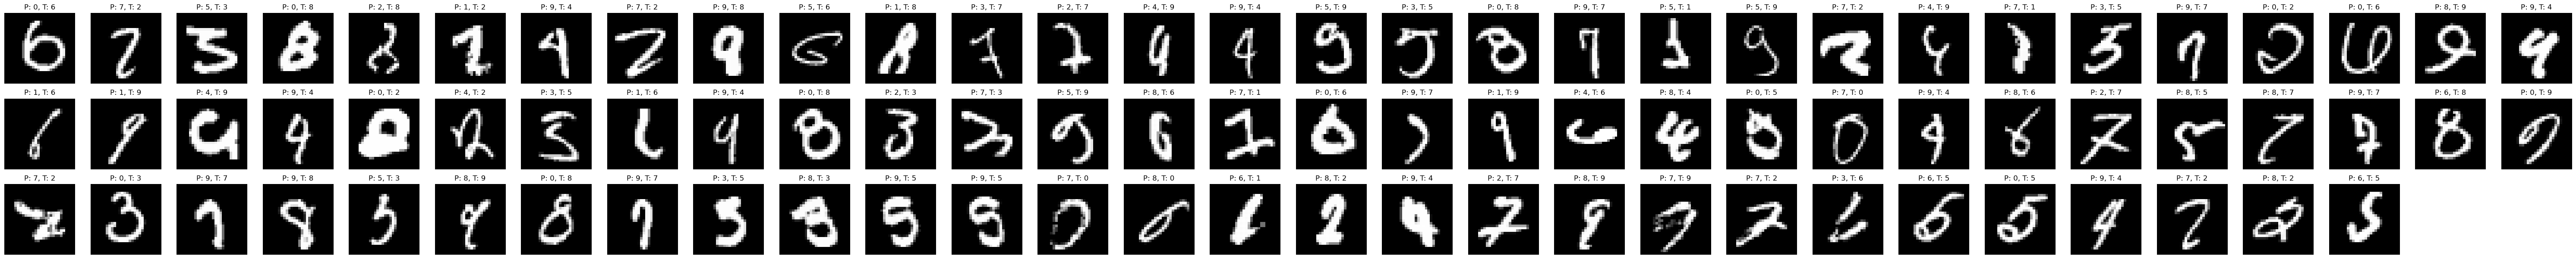

In [9]:
misclassified_val_images = np.where(y_val_pred_classes != y_val_true)[0]

def plot_misclassified(indexes, y_val_pred_classes, y_val_true, images, rows=10, cols=30):
    """Plots a selection of the misclassified images in grid format"""
    n = len(indexes)
    if n > rows * cols:
        print(f"Displaying first {rows * cols} out of {n} misclassified images.")
        n = rows * cols
    
    plt.figure(figsize=(2*cols, 2*rows))
    for i in range(n):
        idx = indexes[i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[idx].reshape(28, 28), cmap='gray')
        plt.title(f"P: {y_val_pred_classes[idx]}, T: {y_val_true[idx]}", fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_misclassified(misclassified_val_images, y_val_pred_classes, y_val_true, x_val)

In [10]:
# Evaluate on each EMNIST Test Set
for i, (x_test_i, y_test_i) in enumerate(test_sets):
    y_test_i_pred = cnn_model.predict(x_test_i)
    y_test_i_pred_classes = np.argmax(y_test_i_pred, axis=1)
    y_test_i_true = np.argmax(y_test_i, axis=1)
    evaluate_performance(y_test_i_true, y_test_i_pred_classes, f"EMNIST Test Set {i+1}")

313/313 [==============================] - 1s 2ms/step
Performance on EMNIST Test Set 1:
Precision: 0.9315
Recall: 0.9249
F1 Score: 0.9210
Confusion Matrix:
[[ 994    0    0    0    0    0    0    0    4    0]
 [   0  934    0    0    3    0    6    1    1    0]
 [   6    5  991    2    2    0    2    1    3    0]
 [   3    0    4  978    0    9    0    1    2    1]
 [   0    1    0    0 1020    0    2    4   12    1]
 [   1    0    0    3    1  984    3    9    9    6]
 [  15    3    1    0    0    0  913    0   14    0]
 [   0   19  113    2    6    0    0  880    6    1]
 [   8    2    2    1    2    9    2    0  988    1]
 [   2    3    3    1  111    3    1  113  204  562]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       998
           1       0.97      0.99      0.98       945
           2       0.89      0.98      0.93      1012
           3       0.99      0.98      0.99       998
           4      

Results are in: 0.99 on validation, 0.89 on EMNIST. 

In [11]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_3 (Dense)             (None, 256)              

# Round 2: Augmentation of the MNIST dataset

Using Keras Sequential API

In [12]:
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation, Resizing, RandomContrast
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Sequential

# Define the CNN model with added complexity and augmentation
cnn_model_enhanced = Sequential([
    InputLayer(input_shape=(28, 28, 1)),
    RandomRotation(0.1),  # Random rotation augmentation, 0.1 radians

    Conv2D(64, kernel_size=(5, 5), activation='relu'), # Increased filters
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'), # Additional Convolutional layer
    MaxPool2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),  # Increased neurons in the dense layer
    Dropout(0.5),

    Dense(128, activation='relu'),  # Additional dense layer
    Dropout(0.5),

    Dense(10, activation='softmax')
])

# Compile the enhanced model
cnn_model_enhanced.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation, Resizing, RandomContrast
from tensorflow.keras.models import Sequential

# Define the CNN model with added complexity and augmentation
cnn_model_enhanced = Sequential([
    InputLayer(input_shape=(28, 28, 1)),
    RandomRotation(0.1),  # Random rotation augmentation, 0.1 radians

    Conv2D(64, kernel_size=(5, 5), activation='relu'),  # Increased filters
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),  # Additional Convolutional layer
    MaxPool2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),  # Increased neurons in the dense layer
    Dropout(0.5),

    Dense(128, activation='relu'),  # Additional dense layer
    Dropout(0.5),

    Dense(10, activation='softmax')
])

# Compile the enhanced model
cnn_model_enhanced.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure validation_split is a float between 0 and 1
cnn_model_enhanced_history = cnn_model_enhanced.fit(x_train_cnn, y_train, epochs=10, batch_size=256, validation_split=0.2)

Epoch 1/10


: 

In [ ]:
cnn_model_enhanced_history = cnn_model_enhanced.fit(x_train_cnn, y_train, epochs = 10, batch_size = 256, validation_split = 0.2)

In [13]:
cnn_enhanced_history = cnn_model_enhanced.fit(x_train_cnn, y_train, epochs=10, batch_size=256, validation_split=0.2)

Epoch 1/10


: 

In [33]:
# Print model summary to see the updated parameter count
cnn_model_enhanced.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_6 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                      

In [5]:
cnn_model_enhanced_2 = Sequential([
    # Data Augmentation Layers
    RandomRotation(0.2),  # Rotations between -20% to 20% of 2pi radians
    RandomZoom(0.2),  # Zoom in or out by 20%
    RandomTranslation(height_factor=0.1, width_factor=0.1),  # Translate by 10% vertically and horizontally
    RandomContrast(0.1),  # Adjust contrast by 10%

    # Input Layer
    InputLayer(input_shape=(28, 28, 1)),

    # Convolutional Layers
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),

    # Flattening the 2D arrays for fully connected layers
    Flatten(),

    # Fully Connected Layers
    Dense(1024, activation='relu'),
    Dropout(0.5),

    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(256, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation='softmax')
])

# Compile the augmented model
cnn_model_enhanced_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model_enhanced_2.build((None, 28, 28, 1))  # None is for the batch size, which can vary

In [6]:
cnn_model_enhanced_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 random_zoom (RandomZoom)    (None, 28, 28, 1)         0         
                                                                 
 random_translation (RandomT  (None, 28, 28, 1)        0         
 ranslation)                                                     
                                                                 
 random_contrast (RandomCont  (None, 28, 28, 1)        0         
 rast)                                                           
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                      

In [7]:
cnn_history_enhanced = cnn_model_enhanced_2.fit(x_train_cnn, y_train, epochs=10, batch_size=256, validation_split=0.2)

Epoch 1/10


2024-02-16 19:55:35.839012: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


: 